# Projet Architecture Big Data

## Matthieu GARRIGUE
## Alexandre CHEVAUX
## Mohammed HAJJI
## Virgile AMATO

In [4]:
# ElasticSearch v6.5.1
import pandas as pd
import elasticsearch as ES
import pyspark
import pymongo 
import sklearn as skl
import sklearn.model_selection as skl_model_selection
import sklearn.linear_model as skl_linear_mdl
import sklearn.ensemble as skl_ensemble_mdl
import sklearn.discriminant_analysis as skl_discriminant_analysis
from sklearn.model_selection import cross_val_score
import sklearn.metrics as skl_metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import os
import time
import json
import requests
import webbrowser
import getpass
import time
import datetime
import platform
import hdfs
import csv
#from sklearn.metrics import roc_curve,auc

# Mongo DB Constants
MONGO_PATH = "C:/Program Files/MongoDB/Server/4.0/bin/mongod"
MONGO_PORT = "27017"
MONGO_HOST = "localhost"
MONGO_URI = MONGO_HOST + ":" + MONGO_PORT
MONGO_URL = "http://" + MONGO_URI

# ElasticSearch Constants
ES_PATH = "C:/Users/Alexandre/elasticsearch-6.5.1/bin/elasticsearch.bat"
ES_PORT = "9200"
ES_HOST = "localhost"
ES_URI = ES_HOST + ":" + ES_PORT
ES_URL = "http://" + ES_URI

# Kibana Constants
KIBANA_PATH = "C:/Users/Alexandre/kibana-6.5.1-windows-x86_64/bin/kibana.bat"
KIBANA_PORT = "5601"
KIBANA_HOST = "localhost"
KIBANA_URI = KIBANA_HOST + ":" + KIBANA_PORT
KIBANA_URL = "http://" + KIBANA_URI

# Universal Constants
DB_NAME = "archi_big_data_db"
BITCOIN_DATASET_PATH = "cryptocurrencypricehistory/bitcoin_price.csv"

# Import et Traitement des Données

## 1) Import des données

### Lancement du serveur MongoDB

In [5]:
# Starting MongoDB Process
print("Starting MongoDB ...")

if platform.system() == "Darwin":
    # Asking For Password, Then pipe it's value to mongo process
    passwd = getpass.getpass("Please enter administrator password : ")
    pass_proc = subprocess.Popen(["echo", str(passwd)],
                                 stdout=subprocess.PIPE)
    mongo_proc = subprocess.Popen(["sudo", "-S", "mongod"],
                                  stdin=pass_proc.stdout,
                                  stdout=subprocess.PIPE)
    pass_proc.terminate()
elif platform.system() == "Windows":
    mongo_proc = subprocess.Popen([MONGO_PATH],
                                  stdout=subprocess.PIPE)
    
elif platform.system() == "Linux":
    mongo_proc = subprocess.Popen(["mongod"],stdout=subprocess.PIPE)

else:
    print("ERROR : PLATFORM NOT RECOGNIZED")
    sys.exit(0)
    
time.sleep(5)

# Check If MongoDB Process is alright
try:
    check_mongod_status = requests.get(MONGO_URL)
    check_mongod_status = check_mongod_status.text
except Exception as e:
    check_mongod_status = "ERROR"
    print(e)
    
if "MongoDB" in check_mongod_status:
    print("MongoDB OK.")
else:
    print("ERROR WHILE CONNECTION TO MONGO DB")

Starting MongoDB ...
MongoDB OK.


### Connection au Client MongoDB

In [6]:
# Connection to MongoDB
conn = pymongo.MongoClient(MONGO_URI)
dbs = conn.list_database_names()
dbs
# Connect to MongoDB Database
db = conn[DB_NAME]
collections_list = db.list_collection_names()
collections_list

['Bitcoin.DailyPrice', 'Test', 'Train']

### Connection au Cluster Hadoop pour lire le fichier CSV (Pandas)

In [10]:
NAMENODE_DNS = "http://ec2-35-180-138-173.eu-west-3.compute.amazonaws.com"
NAMENODE_IP = "http://35.180.138.173"

NAMENODE_WEBUI_PORT = "50070"

# Connection au cluster namenode HDFS
client_url = str(NAMENODE_DNS + ":" + NAMENODE_WEBUI_PORT)
client = hdfs.InsecureClient(client_url, user="ubuntu")

# lecture du fichier
list_csv = []
HDFS_PATH_DATASET = '/home/Projet-ArchitectureBigData/Kaggle-Titanic/complete_dataset.csv'
with client.read(HDFS_PATH_DATASET) as reader:
    raw_csv = reader.read()
raw_csv = raw_csv.decode('utf-8')
csv_list = raw_csv.split("\n")

# parsing du CSV
reader = csv.reader(csv_list)
csv_list = []
for line in reader:
    csv_list.append(line)

# création du dataframe
df = pd.DataFrame(csv_list[1:], 
                  columns=csv_list[0])

# Dealing with empty values
df["Age"][df["Age"] == ""] = -1
df["Age"] = df["Age"].apply(lambda x: float(x))
df["SibSp"][df["SibSp"] == ""] = -1
df["SibSp"] = df["SibSp"].apply(lambda x: float(x))
df["Parch"][df["Parch"] == ""] = -1
df["Parch"] = df["Parch"].apply(lambda x: float(x))
df["Fare"][df["Fare"] == ""] = -1
df["Fare"] = df["Fare"].apply(lambda x: float(x))

df.head(20)

/home/matthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,,S
5,6,0,3,"Moran, Mr. James",male,-1.0,0.0,0.0,330877,8.4583,,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3.0,1.0,349909,21.0750,,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0.0,2.0,347742,11.1333,,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1.0,0.0,237736,30.0708,,C


### Sauvegarde des données sur le serveur MongoDB

In [11]:
# Create collection in MongoDB
# If it already exists, just use it
if not "collection" in locals():
    collection = db["Kaggle_Titanic"]

# Create a list of dictionnaries representing rows to insert
# Befor adding to the list, check if the record exists in the database
rows_to_insert = list()
for i, row in enumerate(df.iterrows()):
    row = dict(row[1])
    record = collection["Datas"].find_one(row)
    if record is None:
        rows_to_insert.append(row)
    if i%100 == 0:
        print(str(i) + " row processed")

# Insert all rows, if doesn't exists
if not len(rows_to_insert) == 0:
    collection["Datas"].insert_many(rows_to_insert)
    print(str(len(rows_to_insert)) + " rows was inserted")
else:
    print("No new lines to insert")

0 row processed
100 row processed
200 row processed
300 row processed
400 row processed
500 row processed
600 row processed
700 row processed
800 row processed
900 row processed
1000 row processed
1100 row processed
1200 row processed
1300 row processed
No new lines to insert


## 2) Traitement des données

### Lecture des données de la base MongoDB

 * Pandas

In [88]:
# Connect to MongoDB Collection
collection = db["Kaggle_Titanic"]
all_prices = collection["Datas"].find({})
df = pd.DataFrame(list(all_prices))
df = df.drop("_id", axis=1)
# MongoDB sometimes include a None at the end of the dataset ... remove it
df = df.dropna()

# Mongo sometimes convert integer to string

df_titanic_train = df[df["Survived"] != "TO_PREDICT"] 
df_titanic_test = df[df["Survived"] == "TO_PREDICT"] 
df_titanic = df_titanic_train

# Dealing with categorical variables 
#sex_categorical = pd.Categorical(df["Sex"])
#sex_dummy = pd.get_dummies(sex_categorical)

#embarked_categorical = pd.Categorical(df["Embarked"])
#embarked_dummy = pd.get_dummies(embarked_categorical)

# categorical variables one-hot encoding
#df = df.drop("Sex", axis=1)
#df[sex_dummy.columns] = sex_dummy
#df = df.drop("Embarked", axis=1)
#df[["Embarked_" + col if col != "" else "Embarked_nothing" for col in embarked_dummy.columns]] = \
#    embarked_dummy

df_titanic.head(20)

NameError: name 'db' is not defined

## lecture de données et machine learning avec Spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [3]:
# on crée une session Spark
ss = SparkSession \
    .builder \
    .appName("Spark ML example on titanic data ") \
    .getOrCreate()

In [4]:
#from pyspark.mllib.regression import LabeledPoint

# On crée notre RDD
trainTitanic = ss.read.csv("/home/matthieu/Documents/Projet-ArchitectureBigData/Titanic/train.csv",header = 'True',inferSchema='True')

In [5]:
trainTitanic.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [6]:
#on regarde le nombre de survivants en fonctions des sexes
trainTitanic.groupBy("Sex","Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



In [7]:
#1 signifie qu'ils ont survécu, il y a eu plus de survivants femme que homme alors que les femmes étaient moins nombreuses sur le bateau

In [8]:
#on remarque que beaucoup de données d'age sont manquantes, il est plus intéressant pour la prédiction de les remplire, c'est pourquoi on calcule l'age moyen pour completer ces cases vides
meanage = round(trainTitanic.select(mean('Age')).collect()[0][0])
print("age moyen:",meanage)

age moyen: 30


In [9]:
#on comble chaque colone vide par l'age moyen

In [10]:
trainTitanic = trainTitanic.withColumn("Age",when (trainTitanic["Age"].isNull(),meanage).otherwise(trainTitanic["Age"]))

In [11]:
# On vérifie qu'il n'y a plus de colonnes d'âge vide

In [12]:
trainTitanic.select("Age").show()

+----+
| Age|
+----+
|22.0|
|38.0|
|26.0|
|35.0|
|35.0|
|30.0|
|54.0|
| 2.0|
|27.0|
|14.0|
| 4.0|
|58.0|
|20.0|
|39.0|
|14.0|
|55.0|
| 2.0|
|30.0|
|31.0|
|30.0|
+----+
only showing top 20 rows



In [13]:
#on retire la colonne "Cabin" qui possède beaucoup de valeurs nulles
trainTitanic = trainTitanic.drop("Cabin")

In [15]:
#on enleve egalement les colonnes non requises
trainTitanic = trainTitanic.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

In [16]:
trainTitanic.show()

+--------+------+----+-----+-----+-------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|
+--------+------+----+-----+-----+-------+
|       0|     3|22.0|    1|    0|   7.25|
|       1|     1|38.0|    1|    0|71.2833|
|       1|     3|26.0|    0|    0|  7.925|
|       1|     1|35.0|    1|    0|   53.1|
|       0|     3|35.0|    0|    0|   8.05|
|       0|     3|30.0|    0|    0| 8.4583|
|       0|     1|54.0|    0|    0|51.8625|
|       0|     3| 2.0|    3|    1| 21.075|
|       1|     3|27.0|    0|    2|11.1333|
|       1|     2|14.0|    1|    0|30.0708|
|       1|     3| 4.0|    1|    1|   16.7|
|       1|     1|58.0|    0|    0|  26.55|
|       0|     3|20.0|    0|    0|   8.05|
|       0|     3|39.0|    1|    5| 31.275|
|       0|     3|14.0|    0|    0| 7.8542|
|       1|     2|55.0|    0|    0|   16.0|
|       0|     3| 2.0|    4|    1| 29.125|
|       1|     2|30.0|    0|    0|   13.0|
|       0|     3|31.0|    1|    0|   18.0|
|       1|     3|30.0|    0|    0|  7.225|
+--------+-

In [17]:
#on envoie les features dans un vecteur
feature = VectorAssembler(inputCols=trainTitanic.columns[1:],outputCol="features")
feature_vector= feature.transform(trainTitanic)

In [18]:
feature_vector.show()

+--------+------+----+-----+-----+-------+--------------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|            features|
+--------+------+----+-----+-----+-------+--------------------+
|       0|     3|22.0|    1|    0|   7.25|[3.0,22.0,1.0,0.0...|
|       1|     1|38.0|    1|    0|71.2833|[1.0,38.0,1.0,0.0...|
|       1|     3|26.0|    0|    0|  7.925|[3.0,26.0,0.0,0.0...|
|       1|     1|35.0|    1|    0|   53.1|[1.0,35.0,1.0,0.0...|
|       0|     3|35.0|    0|    0|   8.05|[3.0,35.0,0.0,0.0...|
|       0|     3|30.0|    0|    0| 8.4583|[3.0,30.0,0.0,0.0...|
|       0|     1|54.0|    0|    0|51.8625|[1.0,54.0,0.0,0.0...|
|       0|     3| 2.0|    3|    1| 21.075|[3.0,2.0,3.0,1.0,...|
|       1|     3|27.0|    0|    2|11.1333|[3.0,27.0,0.0,2.0...|
|       1|     2|14.0|    1|    0|30.0708|[2.0,14.0,1.0,0.0...|
|       1|     3| 4.0|    1|    1|   16.7|[3.0,4.0,1.0,1.0,...|
|       1|     1|58.0|    0|    0|  26.55|[1.0,58.0,0.0,0.0...|
|       0|     3|20.0|    0|    0|   8.0

In [26]:
 #on split les données
(trainingData, testData) = feature_vector.randomSplit([0.75, 0.25],seed = 11)

#### Méthode de régression logistique avec pyspark

In [27]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Survived", featuresCol="features")
#On verifie nos predictions sur l'algo de test
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)
lr_prediction.select("prediction", "Survived", "features").show(30)
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|[1.0,19.0,1.0,0.0...|
|       1.0|       0|[1.0,19.0,3.0,2.0...|
|       1.0|       0|[1.0,27.0,0.0,2.0...|
|       1.0|       0|[1.0,28.0,0.0,0.0...|
|       1.0|       0|[1.0,28.0,1.0,0.0...|
|       1.0|       0|[1.0,29.0,0.0,0.0...|
|       1.0|       0|[1.0,30.0,0.0,0.0...|
|       1.0|       0|[1.0,30.0,0.0,0.0...|
|       1.0|       0|[1.0,30.0,0.0,0.0...|
|       1.0|       0|[1.0,38.0,0.0,1.0...|
|       1.0|       0|(5,[0,1],[1.0,40.0])|
|       1.0|       0|[1.0,40.0,0.0,0.0...|
|       1.0|       0|[1.0,45.0,1.0,0.0...|
|       1.0|       0|[1.0,46.0,0.0,0.0...|
|       0.0|       0|[1.0,47.0,0.0,0.0...|
|       1.0|       0|[1.0,51.0,0.0,1.0...|
|       1.0|       0|[1.0,54.0,0.0,1.0...|
|       0.0|       0|[1.0,58.0,0.0,0.0...|
|       0.0|       0|[1.0,64.0,0.0,0.0...|
|       0.0|       0|[1.0,71.0,0.0,0.0...|
|       1.0

In [28]:
lr_accuracy = evaluator.evaluate(lr_prediction)
print("score régression logistique = %g"% (lr_accuracy))

score régression logistique = 0.711009


#### Méthode de forêt aléatoire avec pyspark

In [29]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
rf = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)
rf_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|[1.0,19.0,1.0,0.0...|
|       1.0|       0|[1.0,19.0,3.0,2.0...|
|       1.0|       0|[1.0,27.0,0.0,2.0...|
|       0.0|       0|[1.0,28.0,0.0,0.0...|
|       1.0|       0|[1.0,28.0,1.0,0.0...|
|       0.0|       0|[1.0,29.0,0.0,0.0...|
|       0.0|       0|[1.0,30.0,0.0,0.0...|
|       0.0|       0|[1.0,30.0,0.0,0.0...|
|       0.0|       0|[1.0,30.0,0.0,0.0...|
|       1.0|       0|[1.0,38.0,0.0,1.0...|
|       0.0|       0|(5,[0,1],[1.0,40.0])|
|       0.0|       0|[1.0,40.0,0.0,0.0...|
|       1.0|       0|[1.0,45.0,1.0,0.0...|
|       1.0|       0|[1.0,46.0,0.0,0.0...|
|       0.0|       0|[1.0,47.0,0.0,0.0...|
|       1.0|       0|[1.0,51.0,0.0,1.0...|
|       1.0|       0|[1.0,54.0,0.0,1.0...|
|       0.0|       0|[1.0,58.0,0.0,0.0...|
|       0.0|       0|[1.0,64.0,0.0,0.0...|
|       0.0|       0|[1.0,71.0,0.0,0.0...|
+----------

In [30]:
rf_accuracy = evaluator.evaluate(rf_prediction)
print("score pour la méthode de forêt aléatoire = %g"% (rf_accuracy))

score pour la méthode de forêt aléatoire = 0.724771


#### Méthode de boosting avec pyspark

In [31]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Survived", featuresCol="features",maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_prediction = gbt_model.transform(testData)
gbt_prediction.select("prediction", "Survived", "features").show(30)

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|[1.0,19.0,1.0,0.0...|
|       1.0|       0|[1.0,19.0,3.0,2.0...|
|       1.0|       0|[1.0,27.0,0.0,2.0...|
|       1.0|       0|[1.0,28.0,0.0,0.0...|
|       1.0|       0|[1.0,28.0,1.0,0.0...|
|       1.0|       0|[1.0,29.0,0.0,0.0...|
|       0.0|       0|[1.0,30.0,0.0,0.0...|
|       1.0|       0|[1.0,30.0,0.0,0.0...|
|       1.0|       0|[1.0,30.0,0.0,0.0...|
|       1.0|       0|[1.0,38.0,0.0,1.0...|
|       0.0|       0|(5,[0,1],[1.0,40.0])|
|       1.0|       0|[1.0,40.0,0.0,0.0...|
|       1.0|       0|[1.0,45.0,1.0,0.0...|
|       1.0|       0|[1.0,46.0,0.0,0.0...|
|       1.0|       0|[1.0,47.0,0.0,0.0...|
|       1.0|       0|[1.0,51.0,0.0,1.0...|
|       1.0|       0|[1.0,54.0,0.0,1.0...|
|       0.0|       0|[1.0,58.0,0.0,0.0...|
|       0.0|       0|[1.0,64.0,0.0,0.0...|
|       0.0|       0|[1.0,71.0,0.0,0.0...|
|       1.0

In [32]:
gbt_accuracy = evaluator.evaluate(gbt_prediction)
print("score avec gradient boosting = %g"% (gbt_accuracy))

score avec gradient boosting = 0.711009


In [157]:
sc.stop()

## 3) Analyse des Données

Dans cette partie nous allons faire du machine learning sur les données récupérées depuis la base mongo DB

### Feature Engineering

In [14]:
df_titanic = df_titanic.drop("Ticket", axis=1)
df_titanic = pd.get_dummies(df_titanic, columns = ["Sex"])
df_titanic["Embarked"] = df_titanic["Embarked"].fillna("S")
df_titanic = pd.get_dummies(df_titanic, columns = ["Embarked"], prefix="Emb")
cpt_row=0

# On génère un indicateur de la "Classe" de la cabine, 0 étant la moins bien et 7 la mieux
for row_titanic in df_titanic["Cabin"]:
    if str(row_titanic)=="":
        df_titanic.loc[[cpt_row], ['Cabin']]=0
    elif str(row_titanic)[0]=="A":
            df_titanic.loc[[cpt_row], ['Cabin']]=1
    elif str(row_titanic)[0]=="B":
            df_titanic.loc[[cpt_row], ['Cabin']]=2
    elif str(row_titanic)[0]=="C":
            df_titanic.loc[[cpt_row], ['Cabin']]=3
    elif str(row_titanic)[0]=="D":
            df_titanic.loc[[cpt_row], ['Cabin']]=4
    elif str(row_titanic)[0]=="E":
            df_titanic.loc[[cpt_row], ['Cabin']]=5
    elif str(row_titanic)[0]=="F":
            df_titanic.loc[[cpt_row], ['Cabin']]=6
    elif str(row_titanic)[0]=="G":
            df_titanic.loc[[cpt_row], ['Cabin']]=7
    else:
        df_titanic.loc[[cpt_row], ['Cabin']]=0
        
    cpt_row=cpt_row+1
    
cpt_row=0
df_titanic["Fare"] = df_titanic["Fare"].astype("float")
#df_titanic["Fare"] = df_titanic["Fare"].fillna(df_titanic["Fare"].median())

for row_titanic in df_titanic["Fare"]:
    if row_titanic<10:
        df_titanic.loc[[cpt_row], ['Fare']]=0
    elif row_titanic>=10 and  row_titanic<50 :
            df_titanic.loc[[cpt_row], ['Fare']]=1
    elif row_titanic>50:
            df_titanic.loc[[cpt_row], ['Fare']]=2
    else:
            df_titanic.loc[[cpt_row], ['Fare']]=0
 
# On utilise la variable nom pour créer des variables indicatives 
# Certains nom contiennt "comptesse" "capitaine", etc ...
df_titanic["FamiliySize"] = df_titanic["SibSp"] + df_titanic["Parch"] + 1
salutation = [i.split(",")[1].split(".")[0].strip() for i in df_titanic["Name"]]
df_titanic["Title"] = pd.Series(salutation)
df_titanic["Title"].unique()
df_titanic["Title"] = df_titanic["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_titanic["Title"] = df_titanic["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df_titanic["Title"] = df_titanic["Title"].astype(int)
df_titanic=df_titanic.drop("Name", axis=1)

df_titanic["Age"] = df_titanic["Age"].fillna(df_titanic["Age"].median())
for row_titanic in df_titanic["Age"]:
    if str(row_titanic)=="":
        df_titanic.loc[[cpt_row], ['Age']]= 1
    elif row_titanic<10 :
        df_titanic.loc[[cpt_row], ['Age']]= 0
    elif row_titanic>=10 and row_titanic<40:
        df_titanic.loc[[cpt_row], ['Age']]= 1
    else:
        df_titanic.loc[[cpt_row], ['Age']]=2
    cpt_row=cpt_row+1
    
df_titanic=df_titanic.dropna()

df_titanic["Survived"] = df_titanic["Survived"].astype("float")

# Reindexing
target = df_titanic["Survived"]
df_titanic = df_titanic.drop("Survived", axis=1)
ids = df_titanic["PassengerId"]
df_titanic = df_titanic.drop("PassengerId", axis=1)

df_titanic["Survived"] = target
df_titanic["PassengerId"] = ids
df_titanic = df_titanic.reindex(np.concatenate((["PassengerId", "Survived"],
                                                df_titanic.columns[:-2].values)),
                                axis=1)

df_titanic.head(20)

,PassengerId,Survived,Age,Cabin,Fare,Parch,Pclass,SibSp,Sex_female,Sex_male,Emb_,Emb_C,Emb_Q,Emb_S,FamiliySize,Title
0,1,0.0,1.0,0,0.0000,0.0,3,1.0,0,1,0,0,0,1,2.0,2
1,2,1.0,1.0,3,71.2833,0.0,1,1.0,1,0,0,1,0,0,2.0,1
2,3,1.0,1.0,0,7.9250,0.0,3,0.0,1,0,0,0,0,1,1.0,1
3,4,1.0,1.0,3,53.1000,0.0,1,1.0,1,0,0,0,0,1,2.0,1
4,5,0.0,1.0,0,8.0500,0.0,3,0.0,0,1,0,0,0,1,1.0,2
5,6,0.0,0.0,0,8.4583,0.0,3,0.0,0,1,0,0,1,0,1.0,2
6,7,0.0,2.0,5,51.8625,0.0,1,0.0,0,1,0,0,0,1,1.0,2
7,8,0.0,0.0,0,21.0750,1.0,3,3.0,0,1,0,0,0,1,5.0,0
8,9,1.0,1.0,0,11.1333,2.0,3,0.0,1,0,0,0,0,1,3.0,1
9,10,1.0,1.0,0,30.0708,0.0,2,1.0,1,0,0,1,0,0,2.0,1


### Estimation des modèle

* Séparation Train set / Test set

In [15]:
df_train, df_test = skl_model_selection.train_test_split(df_titanic)

X = df_titanic.iloc[:, 2:]
Y = df_titanic["Survived"]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# On split le dataset en train-set et test-set
X_train = df_train.iloc[:, 2:]
Y_train = df_train["Survived"].astype("float")
X_test = df_test.iloc[:, 2:]
Y_test = df_test["Survived"].astype("float")

 * Fonction d'affichage de la Matrice de Confusion

In [16]:
def print_confusion_matrix(confusion_matrix, score):
    plt.figure()
    sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=0.3, cmap = 'Blues');
    plt.ylabel('True Label');
    plt.xlabel('Predicted Label');
    plt.title("Score de Prediction : " + str(score))
    plt.show()                         

 * Fonction de calcul du ROC

In [17]:
def get_roc_curve(Y_test, proba_Y, predicted_Y, classe_name): 
    # False Positive Rate
    fpr_cl = dict()
    # True Positive Rate
    tpr_cl = dict()
    fpr_cl[classe_name[0]], tpr_cl[classe_name[0]], _ = \
        skl_metrics.roc_curve(Y_test == 0, proba_Y[:, 0].ravel())
    fpr_cl[classe_name[1]], tpr_cl[classe_name[1]], _ = \
        skl_metrics.roc_curve(Y_test, proba_Y[:, 1].ravel())

    prob_pred = np.array([proba_Y[i, 1 if c else 0]
                         for i, c in enumerate(predicted_Y)])
    
    fpr_cl[classe_name[2]], tpr_cl[classe_name[2]], _ = \
    skl_metrics.roc_curve((predicted_Y == Y_test).ravel(), prob_pred)
    
    # Affichage de la Courbe ROC
    plt.figure()
    for key in fpr_cl:
        plt.plot(fpr_cl[key], tpr_cl[key], label=key)
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Proportion mal classée")
    plt.ylabel("Proportion bien classée")
    plt.title('ROC(s) avec predict_proba')
    plt.legend(loc="lower right")
    
    return(fpr_cl[classe_name[2]], tpr_cl[classe_name[2]])

#### Modèle 1 ) Régression Logistique

In [18]:
df_confusion_matrix = pd.DataFrame(index=["Classe_0", "Classe_1"])
all_scores = pd.DataFrame()

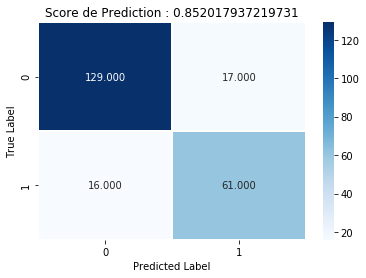

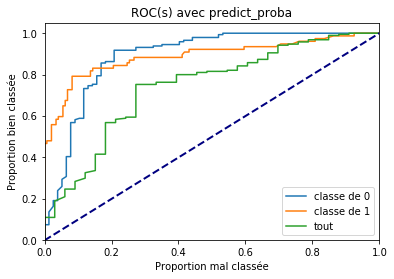

In [19]:
log_reg = skl_linear_mdl.LogisticRegression()
log_reg.fit(X_train, Y_train)
score = log_reg.score(X_test, Y_test)
predicted_Y = log_reg.predict(X_test)
proba_Y = log_reg.predict_proba(X_test)

scores = cross_val_score(log_reg, X, Y, cv=10)

confusion_matrix = skl_metrics.confusion_matrix(Y_test, predicted_Y)
print_confusion_matrix(confusion_matrix,score)
frp_global=[]
tpr_global=[]
AUC_global=dict()

fpr_global=dict()
tpr_global=dict()
fpr_global["Regression Logistique"],tpr_global["Regression Logistique"] =  \
    get_roc_curve(Y_test, proba_Y, predicted_Y, ["classe de 0","classe de 1","tout"])
AUC_global["Regression Logistique"] = \
    skl_metrics.auc(fpr_global["Regression Logistique"],tpr_global["Regression Logistique"])
df_confusion_matrix["Logit_Classe_0"] = confusion_matrix[:, 0]
df_confusion_matrix["Logit_Classe_1"] = confusion_matrix[:, 1]
all_scores.loc[1, "logit"]  = score

#### Modèle 2) Forêts aléatoires

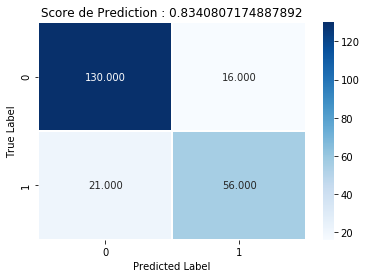

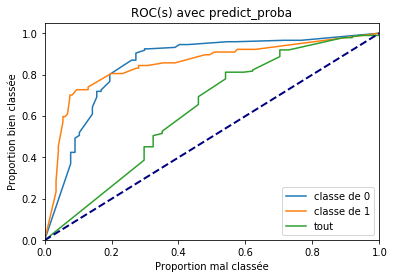

In [20]:
random_forest = skl_ensemble_mdl.RandomForestClassifier()
random_forest.fit(X_train, Y_train)
score = random_forest.score(X_test, Y_test)
predicted_Y = random_forest.predict(X_test)
proba_Y = random_forest.predict_proba(X_test)
true_Y = Y_test


feature_importances = pd.DataFrame(random_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

scores = cross_val_score(random_forest, X, Y, cv=10)
confusion_matrix = skl_metrics.confusion_matrix(true_Y, predicted_Y)
print_confusion_matrix(confusion_matrix,score)

fpr_global["Random Forest"], tpr_global["Random Forest"] = \
    get_roc_curve(Y_test, proba_Y, predicted_Y, ["classe de 0","classe de 1","tout"])
AUC_global["Random Forest"] = \
    skl_metrics.auc(fpr_global["Random Forest"], tpr_global["Random Forest"])
df_confusion_matrix["Random_Forest_Classe_0"] = confusion_matrix[:, 0]
df_confusion_matrix["Random_Forest_Classe_1"] = confusion_matrix[:, 1]
all_scores.loc[1, "rf"]  = score

#### Modèle 3) Analyse linéaire discriminante

/home/matthieu/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/matthieu/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/matthieu/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/matthieu/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/matthieu/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/matthieu/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warn

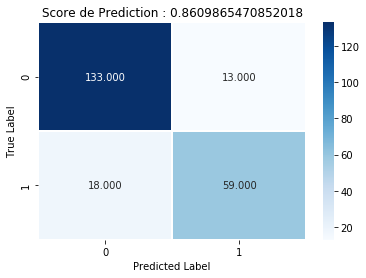

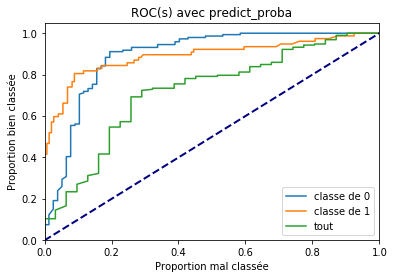

In [21]:
lda = skl_discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
score = lda.score(X_test, Y_test)
predicted_Y = lda.predict(X_test)
proba_Y=lda.predict_proba(X_test)
true_Y = Y_test

scores = cross_val_score(lda, X, Y, cv=10)

confusion_matrix = skl_metrics.confusion_matrix(true_Y, predicted_Y)
print_confusion_matrix(confusion_matrix,score)

fpr_global["ald"],tpr_global["ald"]=get_roc_curve(Y_test,proba_Y,predicted_Y,["classe de 0","classe de 1","tout"])
AUC_global["ald"]=skl_metrics.auc(fpr_global["ald"],tpr_global["ald"])
df_confusion_matrix["ALD_Classe_0"] = confusion_matrix[:, 0]
df_confusion_matrix["ALD_Classe_1"] = confusion_matrix[:, 1]
all_scores.loc[1, "ald"]  = score

### Récapitulation des Modèles Estimés

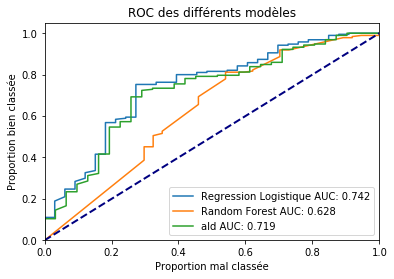

In [22]:
###Print des 3 ROC sur un même graph
for key in fpr_global:
    plt.plot(fpr_global[key], tpr_global[key], label=key +" AUC: " + str(round(AUC_global[key],3)))

lw = 2

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Proportion mal classée")
plt.ylabel("Proportion bien classée")
plt.title('ROC des différents modèles')
plt.legend(loc="lower right")

### Construction d'un Datset ROC pour visualiser les résultats dans Kibana

In [23]:
df_roc_rf = pd.DataFrame()
df_roc_logit = pd.DataFrame()
df_roc_ald = pd.DataFrame()
fpr = list(fpr_global.values())
fpr_logit = fpr[0]
fpr_rf = fpr[1]
fpr_ald = fpr[2]

tpr = list(tpr_global.values())
tpr_logit = tpr[0]
tpr_rf = tpr[1]
tpr_ald = tpr[2]

df_roc_logit["FPR_LOGIT"] = fpr_logit
df_roc_logit["TPR_LOGIT"] = tpr_logit
df_roc_rf["FPR_RF"] = fpr_rf
df_roc_rf["TPR_RF"] = tpr_rf
df_roc_ald["FPR_ALD"] = fpr_ald
df_roc_ald["TPR_ALD"] = tpr_ald

df_roc = df_roc_logit.join(df_roc_rf).join(df_roc_ald)

# On remplace les NaN à la fin de certaines colonnes par 1 : 
# c'est la dernière valeur de chaque colonne 
df_roc = df_roc.fillna(1)

df_roc.head(10)

,FPR_LOGIT,TPR_LOGIT,FPR_RF,TPR_RF,FPR_ALD,TPR_ALD
0,0.000000,0.005263,0.000000,0.000000,0.000000,0.005208
1,0.000000,0.110526,0.297297,0.387097,0.000000,0.104167
2,0.030303,0.110526,0.297297,0.419355,0.032258,0.104167
3,0.030303,0.189474,0.297297,0.435484,0.032258,0.145833
4,0.060606,0.210526,0.297297,0.446237,0.064516,0.166667
5,0.060606,0.247368,0.297297,0.451613,0.064516,0.234375
6,0.090909,0.247368,0.324324,0.451613,0.096774,0.234375
7,0.090909,0.257895,0.324324,0.456989,0.096774,0.244792
8,0.090909,0.268421,0.324324,0.505376,0.096774,0.255208
9,0.090909,0.278947,0.351351,0.516129,0.096774,0.265625


### Sélection des Features les plus importantes pour Kibana

In [24]:
# feature extraction
select_k_best = SelectKBest(score_func=chi2, k=8)
select_k_best_opt = select_k_best.fit(X_train, Y_train)

best_features_index = select_k_best_opt.get_support()
best_features_names = list(X_train.columns[best_features_index])
best_features_scores = pd.DataFrame(list(select_k_best_opt.scores_))

df_best_features = pd.DataFrame()
df_best_features["Feature_Name"] = best_features_names
df_best_features["Score"] = best_features_scores[best_features_index].reset_index(drop=True)
df_best_features = df_best_features.sort_values(by="Score", ascending=False)
df_best_features = df_best_features.reset_index(drop=True)

df_best_features

,Feature_Name,Score
0,Fare,2960.439060
1,Cabin,182.859457
2,Sex_female,117.699090
3,Sex_male,66.429697
4,Title,35.124157
5,Pclass,25.541000
6,Emb_C,12.798378
7,SibSp,5.559077


## 4) Visualisation des données

### On lance les processus : ElasticSearch, Kibana ...

In [25]:
## EN CAS DE PROBLEMES AVEC KIBANA
try:
    requests.delete(ES_URL + "/.kibana")
    requests.delete(ES_URL + "/.kibana_1")
    requests.delete(ES_URL + "/.kibana_2")
    requests.delete(ES_URL + "/.kibana_3")
except Exception as e:
    pass

In [26]:
# Start elastic search process
print("Starting ElasticSearch on " + ES_URL + "...")

if platform.system() == "Darwin":
    es_proc = subprocess.Popen(["elasticsearch"])
elif platform.system() == "Windows":
    es_proc = subprocess.Popen([ES_PATH])
elif platform.system() == "Linux":
    es_proc = subprocess.Popen([ES_PATH])
else:
    print("ERROR : PLATFORM NOT RECOGNIZED")
    sys.exit(0)
    
time.sleep(30)
try:
    # Check if Elastic Search server is running
    check_es_status = requests.get(ES_URL)
    check_es_status = check_es_status.json()
except Exception as e:
    check_es_status = dict()
    es_proc.terminate()
    print("ERROR WHILE GET REQUEST ELASTIC SEARCH : " + str(e))
    
if "cluster_name" in check_es_status.keys():
    print("ElasticSearch OK")
    print("connected on " + ES_URL + ", cluster : " + check_es_status["cluster_name"])
else:
    # Terminate elastic search process
    es_proc.terminate()
    check_es_status = dict()
    print("ERROR RUNNING ELASTICSEARCH")

# Before starting Kibana, check if elastic search is correctly launched
if "cluster_name" in check_es_status.keys():
    print("Starting Kibana on " + KIBANA_URL + "...")
    
    if platform.system() == "Darwin":
        kibana_proc = subprocess.Popen(["kibana"])
    elif platform.system() == "Windows":
        kibana_proc = subprocess.Popen([KIBANA_PATH])
    elif platform.system() == "Linux":
        kibana_proc = subprocess.Popen([KIBANA_PATH])
    else:
        print("ERROR : PLATFORM NOT RECOGNIZED")
        es_proc.terminate()
        sys.exit(0)
        
    time.sleep(10)
    try:
        # Check if Elastic Search server is running
        check_kibana_status = requests.get(KIBANA_URL)
        check_kibana_status = check_kibana_status.text
    except Exception as e:
        check_kibana_status = ""
        print("ERROR WHILE GET REQUEST KIBANA : " + str(e))
    
    # Check if Kibana server is correctly launched
    if not check_kibana_status == "":
        print("Kibana OK")
    else:
        # Terminate Kibana process
        kibana_proc.terminate()
        print("ERROR RUNNING KIBANA")
else:
    print("ERROR RUNNING KIBANA : ELASTIC SEARCH ISN'T COORECTLY STARTED")
    check_kibana_status = ""

if "cluster_name" in check_es_status:
    print("Opening ElasticSearch in the browser at address " + ES_URL)
    webbrowser.open(ES_URL, new=2)
else:
    print("ERROR RUNNING ELASTIC SEARCH, SO NOT OPENING IT IN WEB BROWSER")
if not check_kibana_status == "":
    print("Opening Kibana in the browser at address " + KIBANA_URL)
    webbrowser.open(KIBANA_URL, new=2)
else:
    print("ERROR RUNNING KIBANA, SO NOT OPENING IT IN WEB BROWSER")

Starting ElasticSearch on http://localhost:9200...
ElasticSearch OK
connected on http://localhost:9200, cluster : elasticsearch
Starting Kibana on http://localhost:5601...
Kibana OK
Opening ElasticSearch in the browser at address http://localhost:9200
Opening Kibana in the browser at address http://localhost:5601


### Export des données (création des Index) dans ElasticSearch

 *  Creation de l'index ElasticSearch pour le Dataset entier

In [26]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/titanic_all")
requests.delete(ES_URL + "/titanic_train")
requests.delete(ES_URL + "/titanic_test")
requests.delete(ES_URL + "/machine_learning")
requests.delete(ES_URL + "/confusion_matrix")
requests.delete(ES_URL + "/machine_learning_scores")
requests.delete(ES_URL + "/machine_learning_AUC")

# Create Elastic Search index : "test_index"
#index_mapping_json = json.dumps({"daily_prices" : {
#                                        "dynamic": "true",
#                                        "properties": {
#                                        "Date" : {"type": "date"}
#                                    }
#                                }}
#                               )
#create_index_headers = {"mappings": index_mapping_json}
#r = requests.put(ES_URL + "/bitcoin", headers=create_index_headers)
r = requests.put(ES_URL + "/titanic_all")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
for i, df_row in enumerate(df.iterrows()):
    row_to_dict = dict(df_row[1])
    try:
        r = requests.put(ES_URL + "/titanic_all/dataset_all/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))


# Exemple Requête de données dans Elastic Search
#str_request = "_id:1"
#r = requests.get(ES_URL + "/bitcoin/_search?q=" + str_request)
#r.json()

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'titanic_all'}


 *  Creation de l'index ElasticSearch pour le Dataset d'entrainement

In [27]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/titanic_train")

# Create Elastic Search index : "test_index"
#index_mapping_json = json.dumps({"daily_prices" : {
#                                        "dynamic": "true",
#                                        "properties": {
#                                        "Date" : {"type": "date"}
#                                    }
#                                }}
#                               )
#create_index_headers = {"mappings": index_mapping_json}
#r = requests.put(ES_URL + "/bitcoin", headers=create_index_headers)
r = requests.put(ES_URL + "/titanic_train")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
for i, df_row in enumerate(df_titanic.iterrows()):
    row_to_dict = dict(df_row[1])
    try:
        r = requests.put(ES_URL + "/titanic_train/dataset_train/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))


# Exemple Requête de données dans Elastic Search
#str_request = "_id:1"
#r = requests.get(ES_URL + "/bitcoin/_search?q=" + str_request)
#r.json()

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'titanic_train'}


 *  Creation de l'index ElasticSearch pour le Dataset de test

In [28]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/titanic_test")

# Create Elastic Search index : "test_index"
#index_mapping_json = json.dumps({"daily_prices" : {
#                                        "dynamic": "true",
#                                        "properties": {
#                                        "Date" : {"type": "date"}
#                                    }
#                                }}
#                               )
#create_index_headers = {"mappings": index_mapping_json}
#r = requests.put(ES_URL + "/bitcoin", headers=create_index_headers)
r = requests.put(ES_URL + "/titanic_test")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
for i, df_row in enumerate(df_titanic_test.iterrows()):
    row_to_dict = dict(df_row[1])
    try:
        r = requests.put(ES_URL + "/titanic_test/dataset_test/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))


# Exemple Requête de données dans Elastic Search
#str_request = "_id:1"
#r = requests.get(ES_URL + "/bitcoin/_search?q=" + str_request)
#r.json()

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'titanic_test'}


* Creation de l'index ElasticSearch pour les résultats d'estimation (Courbe Roc)

In [29]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/machine_learning")

# Create Elastic Search index : "test_index"
index_mapping_json = json.dumps({"results" : {
                                        "dynamic": "true",
                                }}
                               )
create_index_headers = {"mappings": index_mapping_json}
r = requests.put(ES_URL + "/machine_learning")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
for i, df_row in enumerate(df_roc.iterrows()):
    row_to_dict = dict(df_row[1])
    try:
        r = requests.put(ES_URL + "/machine_learning/results/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'machine_learning'}


 * Creation de l'index ElasticSearch pour les résultats d'estimation (Confusion Matrix)

In [30]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/confusion_matrix")

# Create Elastic Search index : "test_index"
index_mapping_json = json.dumps({"results" : {
                                        "dynamic": "true",
                                }}
                               )
create_index_headers = {"mappings": index_mapping_json}
r = requests.put(ES_URL + "/confusion_matrix")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
for i, df_row in enumerate(df_confusion_matrix.iterrows()):
    row_to_dict = dict(df_row[1])
    row_to_dict = {key: float(it) for key, it in row_to_dict.items()}
    try:
        r = requests.put(ES_URL + "/confusion_matrix/results/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'confusion_matrix'}


 * Creation de l'index ElasticSearch pour les résultats d'estimation (Prediction Scores)

In [204]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/machine_learning_scores")

# Create Elastic Search index : "test_index"
index_mapping_json = json.dumps({"results" : {
                                        "dynamic": "true",
                                }}
                               )
create_index_headers = {"mappings": index_mapping_json}
r = requests.put(ES_URL + "/machine_learning_scores")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
for i, df_row in enumerate(all_scores.iterrows()):
    row_to_dict = dict(df_row[1])
    row_to_dict = {key: float(it) for key, it in row_to_dict.items()}
    try:
        r = requests.put(ES_URL + "/machine_learning_scores/results/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'machine_learning_scores'}


 * Creation de l'index ElasticSearch pour les résultats d'estimation (AUC)

In [205]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/machine_learning_auc")

# Create Elastic Search index : "test_index"
index_mapping_json = json.dumps({"results" : {
                                        "dynamic": "true",
                                }}
                               )
create_index_headers = {"mappings": index_mapping_json}
r = requests.put(ES_URL + "/machine_learning_auc")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
df_AUC = pd.DataFrame(AUC_global,
                      columns=["Random Forest", "Regression Logistique", "ald"],
                      index=[1])
for i, df_row in enumerate(df_AUC.iterrows()):
    row_to_dict = dict(df_row[1])
    row_to_dict = {key: float(it) for key, it in row_to_dict.items()}
    try:
        r = requests.put(ES_URL + "/machine_learning_auc/results/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'machine_learning_auc'}


* Creation de l'index ElasticSearch pour les résultats d'estimation (Feature Selection)

In [308]:
# If Elastic Search Index already Exists, delete it
requests.delete(ES_URL + "/machine_learning_best_features")

# Create Elastic Search index : "test_index"
index_mapping_json = json.dumps({"results" : {
                                        "dynamic": "true",
                                }}
                               )
create_index_headers = {"mappings": index_mapping_json}
r = requests.put(ES_URL + "/machine_learning_best_features")
print(r.json())

# On remplit l'index Elastic search nouvellement crée
for i, df_row in enumerate(df_best_features.iterrows()):
    row_to_dict = dict(df_row[1])
    print(row_to_dict)
    #row_to_dict = {key: float(it) for key, it in row_to_dict.items()}
    try:
        r = requests.put(ES_URL + "/machine_learning_best_features/results/" + str(i),
                         data=json.dumps(row_to_dict),
                         headers={"content-type":"application/json"})
        jresp = r.json()
        if ("error" in jresp):
            print(jresp)
    except Exception as e:
        print(e)
        print("Error on this row : " + str(row_to_dict))

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'machine_learning_best_features'}
{'Feature_Name': 'Fare', 'Score': 2900.1885064412554}
{'Feature_Name': 'Cabin', 'Score': 195.1578891072212}
{'Feature_Name': 'Sex_female', 'Score': 120.81587903594252}
{'Feature_Name': 'Sex_male', 'Score': 68.18882165728837}
{'Feature_Name': 'Title', 'Score': 32.97188439551437}
{'Feature_Name': 'Pclass', 'Score': 20.640591774475183}
{'Feature_Name': 'Emb_C', 'Score': 11.642411227854897}
{'Feature_Name': 'Emb_S', 'Score': 4.574614862394901}


### Création des Index-Pattern dans Kibana

 * On overwrite l'index .Kibana  dans ElasticSearch pour autoriser la création d'index dans Kibana

In [336]:
requests.delete(ES_URL + "/.kibana")

data_json = {
    "index.mapper.dynamic": "true"
}
data_json = data_json

r = requests.put("http://localhost:9200/.kibana/", headers=data_json)

data_json = {"dynamic": "true"}
r = requests.put("http://localhost:9200/.kibana/_mapping/doc",
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'},
                 data=json.dumps(data_json))
r.json()

{'acknowledged': True}

 * création du titanic_train index-pattern

In [337]:
data_json = {
    "title": "titanic_train",
    #"timeFieldName": "Date"
}

data_json = '{"attributes" : ' + json.dumps(data_json) + '}'

r = requests.post("http://localhost:5601/api/saved_objects/index-pattern/titanic_train?overwrite=true", 
                  data=data_json,
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'}
                 )
r.json()

{'attributes': {'title': 'titanic_train'},
 'id': 'titanic_train',
 'type': 'index-pattern',
 'updated_at': '2018-12-17T17:02:54.874Z',
 'version': 12}

 * création du machine_learing index-pattern

In [338]:
data_json = {
    "title": "machine_learning",
}

data_json = '{"attributes" : ' + json.dumps(data_json) + '}'

r = requests.post("http://localhost:5601/api/saved_objects/index-pattern/machine_learning?overwrite=true", 
                  data=data_json,
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'}
                 )
r.json()

{'attributes': {'title': 'machine_learning'},
 'id': 'machine_learning',
 'type': 'index-pattern',
 'updated_at': '2018-12-17T17:02:55.266Z',
 'version': 12}

* Création du confusion_matrix index-pattern

In [339]:
data_json = {
    "title": "confusion_matrix",
}

data_json = '{"attributes" : ' + json.dumps(data_json) + '}'

r = requests.post("http://localhost:5601/api/saved_objects/index-pattern/confusion_matrix?overwrite=true", 
                  data=data_json,
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'}
                 )
r.json()

{'attributes': {'title': 'confusion_matrix'},
 'id': 'confusion_matrix',
 'type': 'index-pattern',
 'updated_at': '2018-12-17T17:02:56.284Z',
 'version': 12}

* Création du machine_learning_scores index-pattern

In [340]:
data_json = {
    "title": "machine_learning_scores",
}

data_json = '{"attributes" : ' + json.dumps(data_json) + '}'

r = requests.post("http://localhost:5601/api/saved_objects/index-pattern/machine_learning_scores?overwrite=true", 
                  data=data_json,
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'}
                 )
r.json()

{'attributes': {'title': 'machine_learning_scores'},
 'id': 'machine_learning_scores',
 'type': 'index-pattern',
 'updated_at': '2018-12-17T17:02:57.308Z',
 'version': 13}

* Création du machine_learning_auc index-pattern

In [341]:
data_json = {
    "title": "machine_learning_auc",
}

data_json = '{"attributes" : ' + json.dumps(data_json) + '}'

r = requests.post("http://localhost:5601/api/saved_objects/index-pattern/machine_learning_auc?overwrite=true", 
                  data=data_json,
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'}
                 )
r.json()

{'attributes': {'title': 'machine_learning_auc'},
 'id': 'machine_learning_auc',
 'type': 'index-pattern',
 'updated_at': '2018-12-17T17:02:58.353Z',
 'version': 13}

* Création du machine_learning_best_features index-pattern

In [342]:
data_json = {
    "title": "machine_learning_best_features",
}

data_json = '{"attributes" : ' + json.dumps(data_json) + '}'

r = requests.post("http://localhost:5601/api/saved_objects/index-pattern/machine_learning_best_features?overwrite=true", 
                  data=data_json,
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'}
                 )
r.json()

{'attributes': {'title': 'machine_learning_best_features'},
 'id': 'machine_learning_best_features',
 'type': 'index-pattern',
 'updated_at': '2018-12-17T17:02:59.356Z',
 'version': 4}

 * Définition du Default Index

In [343]:
data_json = {
    "value": "titanic_train",
}

data_json = json.dumps(data_json)

r = requests.post("http://localhost:5601/api/kibana/settings/defaultIndex", 
                  data=data_json,
                  headers={"content-type":"application/json", 
                           'kbn-xsrf': 'anything'}
                 )
r.json()

{'settings': {'buildNum': {'userValue': 1},
  'defaultIndex': {'userValue': 'titanic_train'}}}

### Creations des Visualisation dans Kibana

 * Visualizations

In [344]:
all_visualizations = \
    ["Age_VS_Survived",
     "Title_VS_Survived", 
     "Family_Size_VS_Survived",
     "ALD_Classe_0_predictions",
     "ALD_Classe_1_predictions",
     "ALD_ROC",
     "ALD_AUC",
     "ALD_SCORE",
     "Logisitc_Regression_Classe_0_predictions",
     "Logisitic_Regression_Classe_1_predictions",
     "LOGIT_ROC",
     "LOGIT_AUC",
     "LOGIT_SCORE",
     "Random_Forest_Classe_0_predictions",
     "Random_Forest_Classe_1_predictions",
     "RF_ROC",
     "RF_AUC",
     "RF_SCORE"
    ]
    
for vizu in all_visualizations:
    with open("Kibana_SavedObjects/" + vizu + ".json", "r") as f:
        c = f.read()
        c = c.replace(" ", "") \
            .replace("\\n", "").replace("\n", "").replace("\\", "") \
            .replace('"{"', '{"').replace('"}"', '}"') \
            .replace(']}"', ']}').replace('}}"', '}}')
        data_json = c
    data_json = data_json.replace("_id", "id") \
                            .replace("_type", "type") \
                            .replace("_source", "attributes")
        
    d = json.loads(data_json)
    
    visState = json.dumps(d[0]["attributes"]["visState"])
    searchSourceJSON = json.dumps(d[0]["attributes"]["kibanaSavedObjectMeta"]["searchSourceJSON"])
    if type(d[0]["attributes"]["uiStateJSON"]) == type(dict()): 
        uiStateJSON = json.dumps(d[0]["attributes"]["uiStateJSON"])
        d[0]["attributes"]["uiStateJSON"] = uiStateJSON

    d[0]["attributes"]["visState"] = visState
    d[0]["attributes"]["kibanaSavedObjectMeta"]["searchSourceJSON"] = searchSourceJSON

    data_json = json.dumps(d)
    
    if "SCORE" in vizu or "AUC" in vizu:
        data_json = data_json.replace("GreentoRed", "Green to Red")
    
    if "RegressionLogistique" in data_json:
        data_json = data_json.replace("RegressionLogistique", "Regression Logistique")
    
    if "RandomForest" in data_json:
        data_json = data_json.replace("RandomForest", "Random Forest")
    
    request_json =  '{"objects": ' + data_json + '}'

    r = requests.post("http://localhost:5601/api/kibana/dashboards/import?exclude=index-pattern", 
                     data=request_json,
                     headers={"content-type":"application/json", 
                             'kbn-xsrf': 'anything'})
    dic_rep = r.json()["objects"][0]
    
    if "error" in dic_rep.keys():
        print("ERROR : ")
        print(dic_rep["error"]["message"])
    else:
        print("Visualization " + vizu + " was correclty created in Kibana !")

Visualization Age_VS_Survived was correclty created in Kibana !
Visualization Title_VS_Survived was correclty created in Kibana !
Visualization Family_Size_VS_Survived was correclty created in Kibana !
Visualization ALD_Classe_0_predictions was correclty created in Kibana !
Visualization ALD_Classe_1_predictions was correclty created in Kibana !
Visualization ALD_ROC was correclty created in Kibana !
Visualization ALD_AUC was correclty created in Kibana !
Visualization ALD_SCORE was correclty created in Kibana !
Visualization Logisitc_Regression_Classe_0_predictions was correclty created in Kibana !
Visualization Logisitic_Regression_Classe_1_predictions was correclty created in Kibana !
Visualization LOGIT_ROC was correclty created in Kibana !
Visualization LOGIT_AUC was correclty created in Kibana !
Visualization LOGIT_SCORE was correclty created in Kibana !
Visualization Random_Forest_Classe_0_predictions was correclty created in Kibana !
Visualization Random_Forest_Classe_1_predict

 * Feature Importances

In [358]:
all_visualizations = \
    ["Feature_Importances",]
    
for vizu in all_visualizations:
    with open("Kibana_SavedObjects/" + vizu + ".json", "r") as f:
        c = f.read()
        c = c.replace(" ", "") \
            .replace("\\n", "").replace("\n", "").replace("\\", "") \
            .replace('"{"', '{"').replace('"}"', '"}').replace('}"', '}')
        data_json = c
    data_json = data_json.replace("_id", "id") \
                            .replace("_type", "type") \
                            .replace("_source", "attributes")
    d = json.loads(data_json)
    
    visState = json.dumps(d[0]["attributes"]["visState"])
    searchSourceJSON = json.dumps(d[0]["attributes"]["kibanaSavedObjectMeta"]["searchSourceJSON"])
    if type(d[0]["attributes"]["uiStateJSON"]) == type(dict()): 
        uiStateJSON = json.dumps(d[0]["attributes"]["uiStateJSON"])
        d[0]["attributes"]["uiStateJSON"] = uiStateJSON

    d[0]["attributes"]["visState"] = visState
    d[0]["attributes"]["kibanaSavedObjectMeta"]["searchSourceJSON"] = searchSourceJSON
        
    data_json = json.dumps(d)
    
    if 'field\\": \\"id' in data_json :
        data_json = data_json.replace('field\\": \\"id', 'field\\": \\"_id')

    request_json =  '{"objects": ' + data_json + '}'

    r = requests.post("http://localhost:5601/api/kibana/dashboards/import?exclude=index-pattern", 
                     data=request_json,
                     headers={"content-type":"application/json", 
                             'kbn-xsrf': 'anything'})
    dic_rep = r.json()["objects"][0]
    
    if "error" in dic_rep.keys():
        print("ERROR : ")
        print(dic_rep["error"]["message"])
    else:
        print("Visualization " + vizu + " was correclty created in Kibana !")

Visualization Feature_Importances was correclty created in Kibana !


 * Dashboard

In [347]:
all_visualizations = [
    "Dashboard_ALD",
    "Dashboard_Global",
    "Dashboard_Logistic_Regression",
    "Dashboard_Random_Forest"
]

for vizu in all_visualizations:
    with open("Kibana_SavedObjects/" + vizu + ".json", "r") as f:
        c = f.read()
        c = c.replace(" ", "") \
            .replace("\\n", "").replace("\n", "").replace("\\", "").replace('"[', "[").replace(']"', ']') \
            .replace('"{"', '{"').replace('"}"', '}"').replace('}"', "}")
        data_json = c
    data_json = data_json.replace("_id", "id") \
                            .replace("_type", "type") \
                            .replace("_source", "attributes")
    d = json.loads(data_json)
    panelsJSON = json.dumps(d[0]["attributes"]["panelsJSON"])
    d[0]["attributes"]["panelsJSON"] = panelsJSON
    optionsJSON = json.dumps(d[0]["attributes"]["optionsJSON"])
    d[0]["attributes"]["optionsJSON"] = optionsJSON
    searchSourceJSON = json.dumps(d[0]["attributes"]["kibanaSavedObjectMeta"]["searchSourceJSON"])
    d[0]["attributes"]["kibanaSavedObjectMeta"]["searchSourceJSON"] = searchSourceJSON

    data_json = json.dumps(d)

    request_json =  '{"objects": ' + data_json + '}'

    r = requests.post("http://localhost:5601/api/kibana/dashboards/import?exclude=index-pattern", 
                     data=request_json,
                     headers={"content-type":"application/json", 
                             'kbn-xsrf': 'anything'})
    dic_rep = r.json()["objects"][0]
    
    if "error" in dic_rep.keys():
        print("ERROR : ")
        print(dic_rep["error"]["message"])
    else:
        print("Visualization " + vizu + " was correclty created in Kibana !")

Visualization Dashboard_ALD was correclty created in Kibana !
Visualization Dashboard_Global was correclty created in Kibana !
Visualization Dashboard_Logistic_Regression was correclty created in Kibana !
Visualization Dashboard_Random_Forest was correclty created in Kibana !


#### On termine les processus de MongoDB, Kibana et Elastic Search

In [59]:
# Ending MondoDB
print("Ending MongoDB Process ...")
if platform.system() == "Darwin":
    pass_proc = subprocess.Popen(["echo", str(passwd)],
                                stdout=subprocess.PIPE)
    mongod_pid = subprocess.check_output(["pgrep", "mongod"])
    mongod_pid = mongod_pid.decode('utf-8')
    mongod_pid = mongod_pid.replace("\n", "")
    kill_proc = subprocess.Popen(["sudo", "-S", "kill", str(mongod_pid)],
                                  stdin=pass_proc.stdout,
                                  stdout=subprocess.PIPE)
    kill_proc.communicate()
    pass_proc.terminate()
    kill_proc.terminate()
    
if platform.system() == "Windows":
    mongo_proc.kill
    
print("Ended MongoDB Process.")

# Ending ElasticSearch
print("Ending ElasticSearch Process...")
es_proc.terminate()
print("Ended ElasticSearch Process.")

# Ending Kibana
print("Ending Kibana Process...")
kibana_proc.terminate()
print("Ended Kibana Process.")

Ending MongoDB Process ...
Ended MongoDB Process.
Ending ElasticSearch Process...
Ended ElasticSearch Process.
Ending Kibana Process...
Ended Kibana Process.


### Administration du cluster Hadoop (Au besoin)

In [3]:
NAMENODE_DNS = "http://ec2-35-180-138-173.eu-west-3.compute.amazonaws.com"
NAMENODE_IP ="http://35.180.138.173"

DATANODE_1_DNS = "http://ec2-35-180-128-32.eu-west-3.compute.amazonaws.com"
DATANODE_1_IP = "http://35.180.128.32"

NAMENODE_WEBUI_PORT = "50070"
DATANODE_1_WEBUI_PORT = "50075"

client_url = str(NAMENODE_DNS + ":" + NAMENODE_WEBUI_PORT)
client = hdfs.InsecureClient(client_url, user="ubuntu")

 * List HDFS directories

In [5]:
# Liste Files and Directories
for onedir in client.walk("/"):
    print(onedir)

('/', ['home'], [])
('/home', ['Projet-ArchitectureBigData', 'Projet2_Simulations&Copules'], [])
('/home/Projet-ArchitectureBigData', ['.ipynb_checkpoints', 'Kaggle-TwoSigma', 'Kibana_SavedObjects', 'cryptocurrencypricehistory'], ['.DS_Store', 'Projet-ArchiBigData.ipynb', 'Projet-ArchiBigData_OLD.ipynb', 'TweetsStreamer.ipynb'])
('/home/Projet-ArchitectureBigData/.ipynb_checkpoints', [], ['Projet-ArchiBigData-checkpoint.ipynb', 'Untitled-checkpoint.ipynb'])
('/home/Projet-ArchitectureBigData/Kaggle-TwoSigma', [], ['marketdata_sample.csv', 'news_sample.csv'])
('/home/Projet-ArchitectureBigData/Kibana_SavedObjects', [], ['Close_Return_Visualization.json', 'Courbe Roc.json', 'Moving_STD_3D-6D-9D.json', 'TestDashboard.json', 'Total_Positive_Returns_Over_Time.json'])
('/home/Projet-ArchitectureBigData/cryptocurrencypricehistory', [], ['bitcoin_cash_price.csv', 'bitcoin_dataset.csv', 'bitcoin_price.csv', 'bitconnect_price.csv', 'dash_price.csv', 'ethereum_classic_price.csv', 'ethereum_datase

 * Upload file to HDFS 

In [7]:
client.upload(hdfs_path="/home/Projet-ArchitectureBigData",
              local_path="/Users/virgileamato/Desktop/Projet-ArchitectureBigData/Kaggle-Titanic",
              overwrite=True)

def upload_file(path_to_file):
    client.upload(hdfs_path="/home", local_path=path_to_file, overwrite=True)

 * Download file from HDFS

In [ ]:
#client.download("/home/", local_path="/Users/virgileamato/Desktop")

def download_file(hdfs_path, local_path):
    client.download(hdfs_path, local_path=local_path)

 * Read file from HDFS

In [ ]:
def read_file(hdfs_path):
    with client.read(hdfs_path) as reader:
        raw_file = reader.read()
    
    raw_file = raw_file.decode('utf-8')
    
    return raw_file

 * Write from to HDFS

In [ ]:
def write_file(hdfs_path, str_to_write):
    with client.write(hdfs_path, overwrite=True) as writer:
        writer.write(str_to_write.encode())

 * Delete file from HDFS

In [ ]:
#client.delete("/home/core-site.xml")

def delete_file(hdfs_path):
    client.delete(hdfs_path)